In [ ]:
import os
import logging

import numpy as np
import scanpy as sc
%config InlineBackend.figure_format = 'retina'

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s')

from thor.simulation import simulate_spot

datadir=os.path.join(os.getcwd(), 'slide_seq')
outdir=os.path.join(os.getcwd(), 'gex_dropouts')

We will use the cell populations and positions from a slide-seq data as template and simulate expression using Splatter.

In [3]:
template_adata_path = os.path.join(datadir, "cell_balanced_unfiltered.h5ad")
ad_temp = sc.read_h5ad(template_adata_path)

In [106]:
groupProb = ad_temp.obs['clusters'].value_counts() / ad_temp.shape[0]
groupProb

Granular                0.452652
Purkinje                0.331965
Oligo Polydendrocyte    0.215382
Name: clusters, dtype: float64

In [8]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

rpy2.situation - INFO - cffi mode is CFFI_MODE.ANY
rpy2.situation - INFO - R home found: /Library/Frameworks/R.framework/Resources
rpy2.situation - INFO - R library path: 
rpy2.situation - INFO - LD_LIBRARY_PATH: 
rpy2.rinterface_lib.embedded - INFO - Default options to initialize R: rpy2, --quiet, --no-save
rpy2.rinterface_lib.embedded - INFO - R is already initialized. No need to initialize.


In [9]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

library(splatter)

simulate_single_cell <- function(groupProb=c(0.452652, 0.331965, 0.215382), nGenes = 200, nCells = 7000, dropoutType = 'experiment', dropoutMid = 1, seed = 101)
{
    params <- newSplatParams()
    params <- setParam(params, "nGenes", nGenes)
    params <- setParam(params, "batchCells", nCells)
    params <- setParam(params, "dropout.type", dropoutType)
    params <- setParam(params, "dropout.mid", dropoutMid)
    params <- setParam(params, "group.prob", groupProb)
    params <- setParam(params, "seed", seed)

    sim.groups <- splatSimulate(params, method = 'group', verbose = FALSE)
    counts     <- as.data.frame(t(counts(sim.groups)))
    truecounts <- as.data.frame(t(assays(sim.groups)$TrueCounts))

    dropout    <- assays(sim.groups)$Dropout

    cellinfo   <- as.data.frame(colData(sim.groups))
    geneinfo   <- as.data.frame(rowData(sim.groups))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
} 

sim <- simulate_single_cell()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

rpy2.rinterface_lib.callbacks - WARNING - R[write to console]: Loading required package: SingleCellExperiment

rpy2.rinterface_lib.callbacks - WARNING - R[write to console]: Loading required package: SummarizedExperiment

rpy2.rinterface_lib.callbacks - WARNING - R[write to console]: Loading required package: MatrixGenerics

rpy2.rinterface_lib.callbacks - WARNING - R[write to console]: Loading required package: matrixStats

rpy2.rinterface_lib.callbacks - WARNING - R[write to console]: 
Attaching package: ‘MatrixGenerics’


rpy2.rinterface_lib.callbacks - WARNING - R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, 

In [ ]:
def create_adata(counts, cellinfo, geneinfo, cell_pos, template_adata_path): 
    adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
    adata.obs_names = cellinfo.Cell
    adata.var_names = geneinfo.Gene
    sc.pp.filter_genes(adata, min_counts=1)

    adata.obsm['spatial'] = cell_pos
    adata.uns['template'] = template_adata_path

    return adata


def get_spatial_info(counts, geneinfo, cellinfo, truecounts, template_adata_path):
    ad_temp = sc.read_h5ad(template_adata_path)
    clusters = ad_temp.obs['clusters'].value_counts().index
    rename_dict = dict(zip(cellinfo.Group.cat.categories, clusters))
    cellinfo['clusters'] = cellinfo['Group'].map(rename_dict)

    selected = []
    reorder_cells_indices = []
    for cl in clusters:
        cells_cl = cellinfo[cellinfo['clusters'] == cl].index
        cells_temp = ad_temp[ad_temp.obs['clusters'] == cl].obs_names
        selected.append(np.random.choice(cells_cl, size=len(cells_temp), replace=False))
        reorder_cells_indices.append(cells_temp)

    cellindex = np.concatenate(selected)
    reorder_cells_indices = np.concatenate(reorder_cells_indices)
    cell_pos = ad_temp[reorder_cells_indices].obsm['spatial']

    cellinfo = cellinfo.loc[cellindex]
    truecounts = truecounts.loc[cellindex]
    counts = counts.loc[cellindex]

    ad_sim_drop = create_adata(counts, cellinfo, geneinfo, cell_pos, template_adata_path)
    ad_sim_true = create_adata(truecounts, cellinfo, geneinfo, cell_pos, template_adata_path)

    return ad_sim_drop, ad_sim_true


ad_sim_drop, ad_sim_true = get_spatial_info(counts, geneinfo, cellinfo, truecounts, template_adata_path)
ad_sim_true.write_h5ad(os.path.join(outdir, "cell_balanced_unfiltered_splatter.h5ad"))
ad_sim_drop.write_h5ad(os.path.join(outdir, "cell_balanced_unfiltered_splatter_gex_drop.h5ad"))

/var/folders/2p/2j0f_d_13815dk9jyzwnfl540000gp/T/ipykernel_55053/3627904206.py:2: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
/var/folders/2p/2j0f_d_13815dk9jyzwnfl540000gp/T/ipykernel_55053/3627904206.py:2: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
... storing 'Batch' as categorical
... storing 'Batch' as categorical


... storing 'Batch' as categorical
/Users/pengzhizhang/miniconda3/envs/histocartography/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


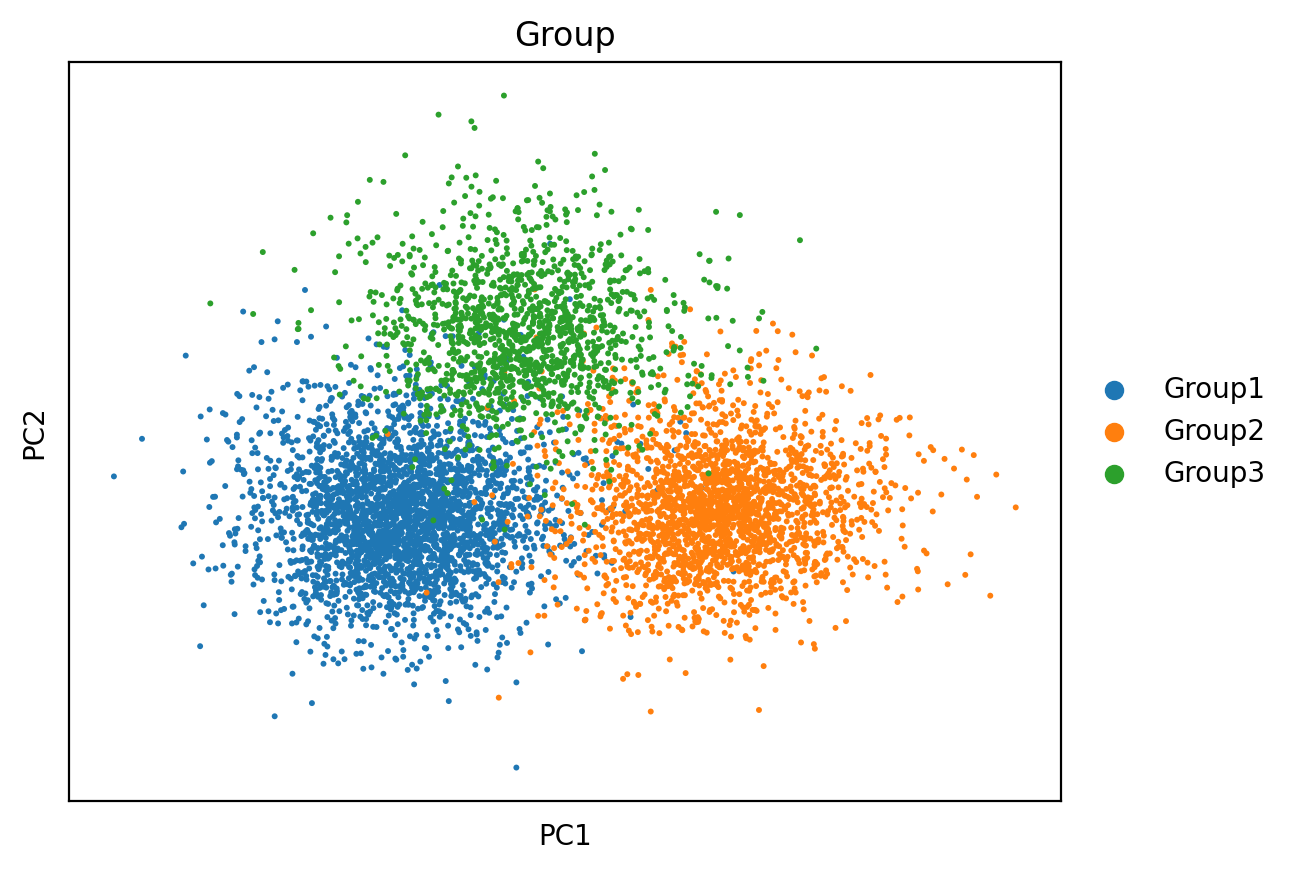

In [198]:
sc.pp.normalize_total(ad_sim_drop)
sc.pp.log1p(ad_sim_drop)
sc.tl.pca(ad_sim_drop)
sc.pl.pca(ad_sim_drop, color='Group')

... storing 'Batch' as categorical
/Users/pengzhizhang/miniconda3/envs/histocartography/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


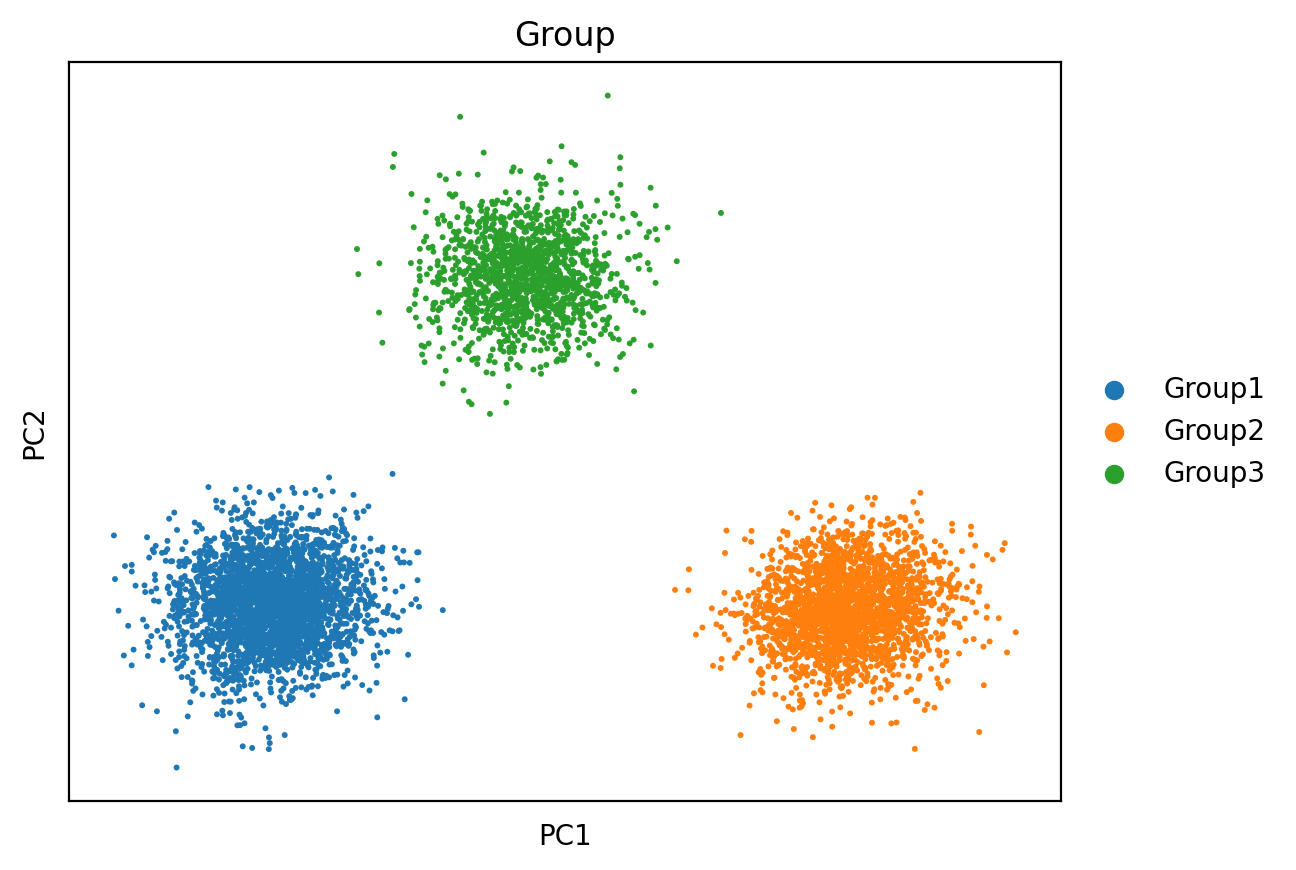

In [205]:
sc.pp.normalize_total(ad_sim_true)
sc.pp.log1p(ad_sim_true)
sc.tl.pca(ad_sim_true)
sc.pl.pca(ad_sim_true, color='Group')

## Creating spots from the simulated data

In [21]:
spot_size = 100

ad_spot_ori = simulate_spot(os.path.join(outdir, "cell_balanced_unfiltered_splatter.h5ad"), spot_sep=spot_size, layer_key=None)
ad_spot_ori.write_h5ad(os.path.join(outdir, f"simulated_cerebellum_spotsize_{spot_size}_splatter.h5ad" ))
sc.pp.normalize_total(ad_spot_ori)
sc.pp.log1p(ad_spot_ori)

/Users/pengzhizhang/miniconda3/envs/histocartography/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'major clusters' as categorical


In [23]:
ad_spot_drop = simulate_spot(os.path.join(outdir, "cell_balanced_unfiltered_splatter_gex_drop.h5ad"), spot_sep=100, layer_key=None)
ad_spot_drop.write_h5ad(os.path.join(outdir, f"simulated_cerebellum_spotsize_{spot_size}_splatter_gex_drop.h5ad"))
sc.pp.normalize_total(ad_spot_drop)
sc.pp.log1p(ad_spot_drop)

/Users/pengzhizhang/miniconda3/envs/histocartography/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'major clusters' as categorical


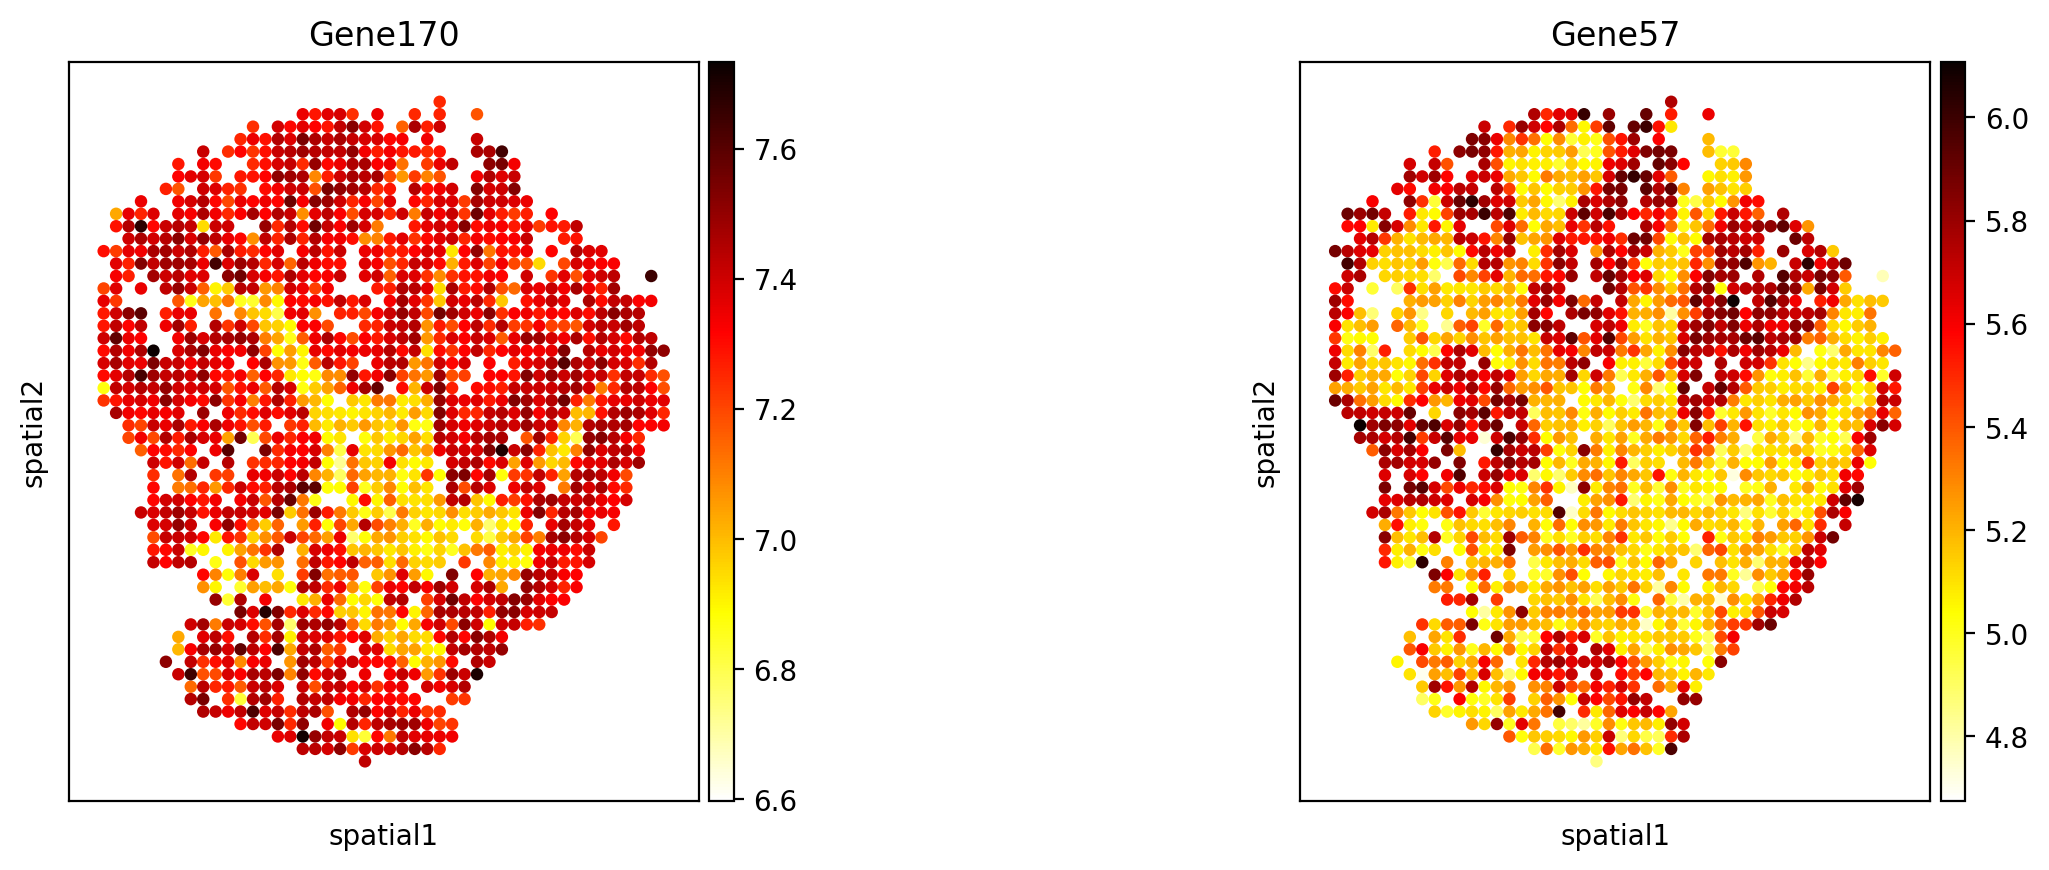

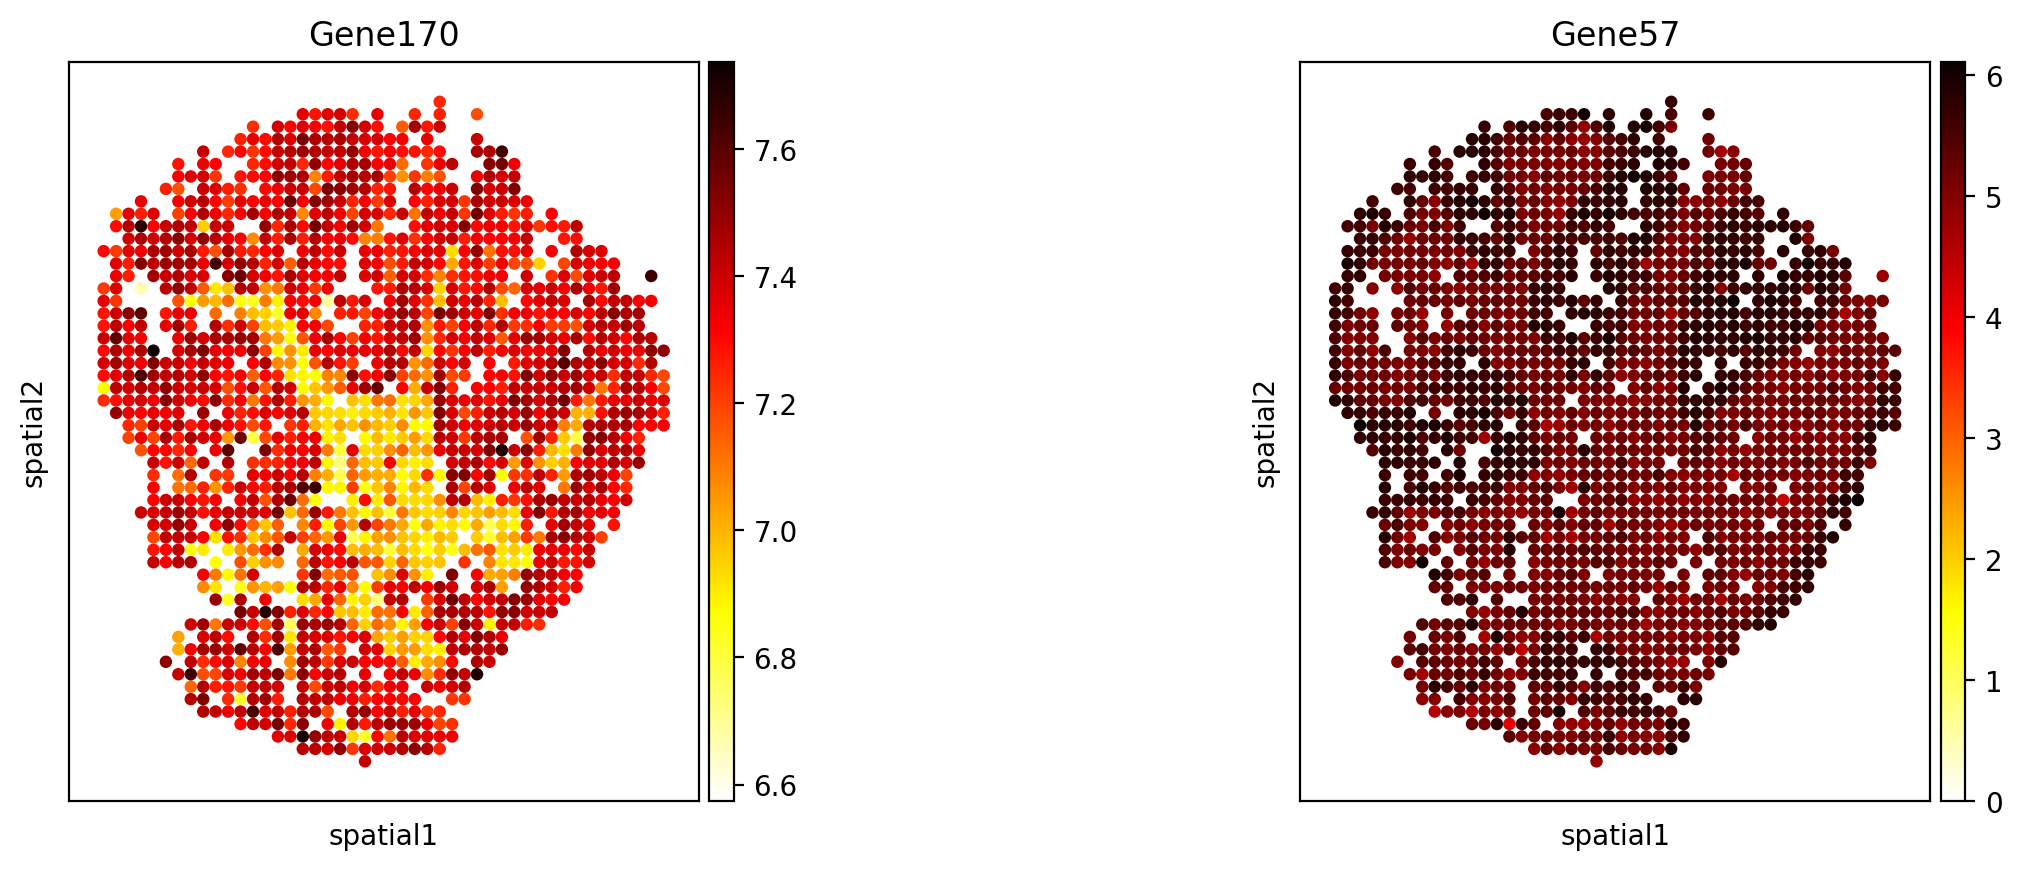

In [14]:
sc.pl.spatial(ad_spot_ori, spot_size=100, color=['Gene170', 'Gene57'], cmap='hot_r')
sc.pl.spatial(ad_spot_drop, spot_size=100, color=['Gene170', 'Gene57'], cmap='hot_r')